In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Sample dataset

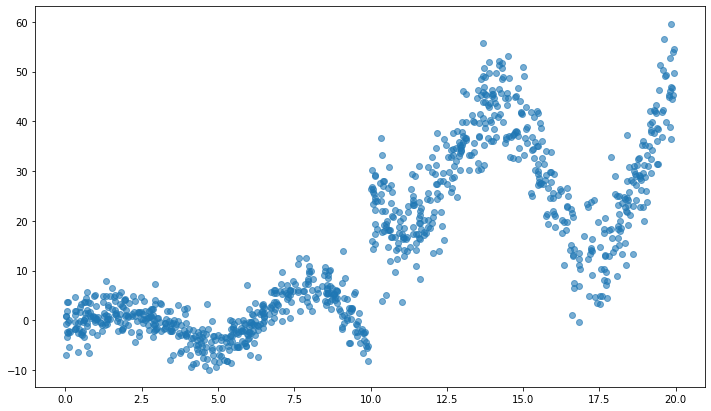

In [17]:
# Data
X1 = np.atleast_2d(np.random.uniform(0, 10.0, size = 500)).T
X1 = X1.astype(np.float32)
y1 = (X1*np.sin(X1)).ravel()
dy1 = 1 + 3 * np.random.random(y1.shape)
y1 = y1 + np.random.normal(0, dy1)
y1 = y1.astype(np.float32)

X2 = np.atleast_2d(np.random.uniform(10, 20.0, size = 500)).T
X2 = X2.astype(np.float32)
y2 = (X2*np.sin(X2)).ravel()
dy2 = 5 + 1 * np.random.random(y2.shape)
y2 = y2 + np.random.normal(0, dy2) + 30
y2 = y2.astype(np.float32)

X = np.concatenate([X1, X2])
y = np.concatenate([y1, y2])

# Plot
plt.figure(figsize = (12, 7))
plt.scatter(X, y, alpha = 0.6)
plt.show()

# Model

In [3]:
# Settings
minibatch_size = 128
quantiles = [0.1, 0.5, 0.9]
lr = 0.01
weight_decay = 1e-6
epochs = 1000

In [4]:
# Model
class QRModel(nn.Module):
    def __init__(self, n_input, quantiles):
        super().__init__()
        self.quantiles = quantiles
        self.n_output = len(quantiles)
        self.fc1 = nn.Linear(n_input, 64, bias = True)
        self.fc2 = nn.Linear(64, 32, bias = True)
        self.fc3 = nn.Linear(32, self.n_output, bias = True)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.fc3(output)
        return output

In [5]:
# Dataset
class SampleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).view(-1, 1)
        self.data_length = len(self.y)
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.scaler_X.fit(self.X)
        self.scaler_y.fit(self.y)
        self.scaled_X = self.scaler_X.transform(self.X)
        self.scaled_y = self.scaler_y.transform(self.y)
        self.scaled_X = torch.FloatTensor(self.scaled_X)
        self.scaled_y = torch.FloatTensor(self.scaled_y)
        
    def __getitem__(self, index):
        return self.scaled_X[index], self.scaled_y[index]
    
    def __len__(self):
        return self.data_length

In [6]:
# Loss function
class PinbollLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, pred_values, actual_values):
        losses = []
        for i, q in enumerate(self.quantiles):
            loss_values = actual_values - pred_values[:,i].view(-1, 1)
            loss_values = torch.max((q-1)*loss_values, q*loss_values)
            losses.append(loss_values)
        loss = torch.cat(losses, dim = 1)
        loss = torch.sum(loss, dim = 1)
        loss = torch.mean(loss)
        return loss

In [7]:
# Instantiation
dataset = SampleDataset(X, y)
loader = DataLoader(dataset =  dataset, batch_size = minibatch_size, shuffle = True)
model = QRModel(n_input = dataset.scaled_X.size()[1], quantiles = quantiles)
loss_function = PinbollLoss(quantiles = quantiles)
optimizer = torch.optim.Adam(params = model.parameters(), lr = lr, weight_decay = weight_decay)

# Training

In [8]:
# Trainning
model.train()
iteration_losses = []

for epoch in range(epochs):
    epoch_losses = []
    for X_train, y_train in loader:
        pred_values = model(X_train)
        loss = loss_function(pred_values, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iteration_losses.append(loss.detach())
        epoch_losses.append(loss.detach())
    if (epoch+1)%100 == 0:
        print("Epoch {}: {}".format(epoch+1, np.mean(epoch_losses)))

Epoch 100: 0.23283961415290833
Epoch 200: 0.21555742621421814
Epoch 300: 0.20836032927036285
Epoch 400: 0.20862729847431183
Epoch 500: 0.208831787109375
Epoch 600: 0.20498742163181305
Epoch 700: 0.20649805665016174
Epoch 800: 0.21009859442710876
Epoch 900: 0.206511989235878
Epoch 1000: 0.2107039988040924


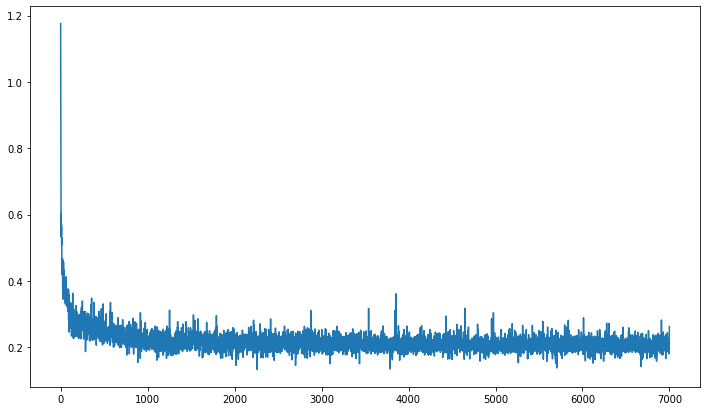

In [9]:
# Loss plot
plt.figure(figsize = (12, 7))
plt.plot(iteration_losses)
plt.show()

# Regression line

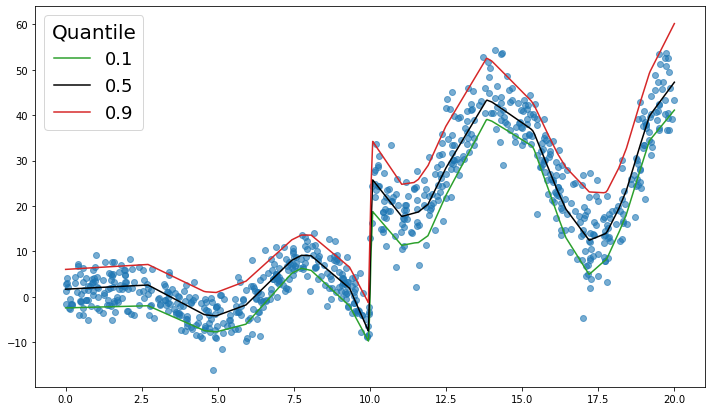

In [10]:
# Prediction
lineX = np.linspace(0, 20, 10000).reshape(-1, 1)
model.eval()
with torch.no_grad():
    scaled_pred_values = model(torch.FloatTensor(dataset.scaler_X.transform(lineX)))

# Plot
plt.figure(figsize = (12, 7))
plt.scatter(X, y, alpha = 0.6)

for i, (q, color) in enumerate(zip(quantiles, ["tab:green", "black", "tab:red"])):
    plt.plot(lineX.ravel(), dataset.scaler_y.inverse_transform(scaled_pred_values[:,i].view(-1, 1)).ravel(), color = color, label = str(q))
plt.legend(fontsize = 18, title = "Quantile", title_fontsize = 20)
plt.show()